In [1]:
import os
import torch
import numpy as np
import configargparse
import argparse
import sys
from model.lidar4d import LiDAR4D
from model.runner import Trainer
from utils.metrics import DepthMeter, IntensityMeter, RaydropMeter, PointsMeter, LabelMeter
from utils.misc import set_seed

/root/docker_data/MSthesis/model/activation.py:8: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd(cast_inputs=torch.float32)  # cast to float32
/root/docker_data/MSthesis/model/activation.py:15: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, g):


Loaded compiled 3D CUDA chamfer distance
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def get_arg_parser():
    parser = configargparse.ArgumentParser()

    parser.add_argument("--config", is_config_file=True, default="configs/kitti360_4950.txt", help="config file path")
    parser.add_argument("--workspace", type=str, default="workspace")
    parser.add_argument("--refine", action="store_true", help="refine mode")
    parser.add_argument("--test", action="store_true", help="test mode")
    parser.add_argument("--test_eval", action="store_true", help="test and eval mode")
    parser.add_argument("--seed", type=int, default=0)

    ### dataset
    parser.add_argument("--dataloader", type=str, choices=("kitti360", "nuscenes"), default="kitti360")
    parser.add_argument("--path", type=str, default="data/kitti360", help="dataset root path")
    parser.add_argument("--sequence_id", type=str, default="4950")
    parser.add_argument("--preload", type=bool, default=True, help="preload all data into GPU, accelerate training but use more GPU memory")
    parser.add_argument("--bound", type=float, default=1, help="assume the scene is bounded in box[-bound, bound]^3")
    parser.add_argument("--scale", type=float, default=0.01, help="scale lidar location into box[-bound, bound]^3")
    parser.add_argument("--offset", type=float, nargs="*", default=[0, 0, 0], help="offset of lidar location")
    parser.add_argument("--near_lidar", type=float, default=1.0, help="minimum near distance for lidar")
    parser.add_argument("--far_lidar", type=float, default=81.0, help="maximum far distance for lidar")
    parser.add_argument("--fov_lidar", type=float, nargs="*", default=[2.0, 26.9], help="fov up and fov range of lidar")
    parser.add_argument("--num_frames", type=int, default=51, help="total number of sequence frames")

    ### LiDAR4D
    parser.add_argument("--min_resolution", type=int, default=32, help="minimum resolution for planes")
    parser.add_argument("--base_resolution", type=int, default=512, help="minimum resolution for hash grid")
    parser.add_argument("--max_resolution", type=int, default=32768, help="maximum resolution for hash grid")
    parser.add_argument("--time_resolution", type=int, default=8, help="temporal resolution")
    parser.add_argument("--n_levels_plane", type=int, default=4, help="n_levels for planes")
    parser.add_argument("--n_features_per_level_plane", type=int, default=8, help="n_features_per_level for planes")
    parser.add_argument("--n_levels_hash", type=int, default=8, help="n_levels for hash grid")
    parser.add_argument("--n_features_per_level_hash", type=int, default=4, help="n_features_per_level for hash grid")
    parser.add_argument("--log2_hashmap_size", type=int, default=19, help="hashmap size for hash grid")
    parser.add_argument("--num_layers_flow", type=int, default=3, help="num_layers of flownet")
    parser.add_argument("--hidden_dim_flow", type=int, default=64, help="hidden_dim of flownet")
    parser.add_argument("--num_layers_sigma", type=int, default=2, help="num_layers of sigmanet")
    parser.add_argument("--hidden_dim_sigma", type=int, default=64, help="hidden_dim of sigmanet")
    parser.add_argument("--geo_feat_dim", type=int, default=15, help="geo_feat_dim of sigmanet")
    parser.add_argument("--num_layers_lidar", type=int, default=3, help="num_layers of intensity/raydrop")
    parser.add_argument("--hidden_dim_lidar", type=int, default=64, help="hidden_dim of intensity/raydrop")
    parser.add_argument("--out_lidar_dim", type=int, default=3, help="output dim for lidar intensity/raydrop")

    ### training
    parser.add_argument("--depth_loss", type=str, default="l1", help="l1, bce, mse, huber")
    parser.add_argument("--depth_grad_loss", type=str, default="l1", help="l1, bce, mse, huber")
    parser.add_argument("--intensity_loss", type=str, default="mse", help="l1, bce, mse, huber")
    parser.add_argument("--raydrop_loss", type=str, default="mse", help="l1, bce, mse, huber")
    parser.add_argument("--label_loss", type=str, default="l1", help="l1, bce, mse, huber")
    parser.add_argument("--flow_loss", type=bool, default=True)
    parser.add_argument("--grad_loss", type=bool, default=True)

    parser.add_argument("--alpha_d", type=float, default=1)
    parser.add_argument("--alpha_i", type=float, default=0.1)
    parser.add_argument("--alpha_l", type=float, default=0.1)
    parser.add_argument("--alpha_r", type=float, default=0.01)
    parser.add_argument("--alpha_grad", type=float, default=0.1)
    parser.add_argument("--alpha_grad_norm", type=float, default=0.1)
    parser.add_argument("--alpha_spatial", type=float, default=0.1)
    parser.add_argument("--alpha_tv", type=float, default=0.1)

    parser.add_argument("--grad_norm_smooth", action="store_true")
    parser.add_argument("--spatial_smooth", action="store_true")
    parser.add_argument("--tv_loss", action="store_true")
    parser.add_argument("--sobel_grad", action="store_true")
    parser.add_argument("--urf_loss", action="store_true", help="enable line-of-sight loss in URF.")
    parser.add_argument("--active_sensor", action="store_true", help="enable volume rendering for active sensor.")

    parser.add_argument("--density_scale", type=float, default=1)
    parser.add_argument("--intensity_scale", type=float, default=1)
    parser.add_argument("--raydrop_ratio", type=float, default=0.5)
    parser.add_argument("--smooth_factor", type=float, default=0.2)

    parser.add_argument("--iters", type=int, default=30000, help="training iters")
    parser.add_argument("--lr", type=float, default=1e-2, help="initial learning rate")
    parser.add_argument("--fp16", type=bool, default=True, help="use amp mixed precision training")
    parser.add_argument("--eval_interval", type=int, default=100)
    parser.add_argument("--ckpt", type=str, default="latest")
    parser.add_argument("--num_rays_lidar", type=int, default=1024, help="num rays sampled per image for each training step")
    parser.add_argument("--num_steps", type=int, default=768, help="num steps sampled per ray")
    parser.add_argument("--patch_size_lidar", type=int, default=1, help="[experimental] render patches in training." 
                                                                        "1 means disabled, use [64, 32, 16] to enable")
    parser.add_argument("--change_patch_size_lidar", nargs="+", type=int, default=[2, 8], help="[experimental] render patches in training. " 
                                                                      "1 means disabled, use [64, 32, 16] to enable, change during training")
    parser.add_argument("--change_patch_size_epoch", type=int, default=2, help="change patch_size intenvel")
    parser.add_argument("--ema_decay", type=float, default=0.95, help="use ema during training")

    return parser

In [3]:
sys.argv = ["/root/docker_data/LiDAR4D/configs/kitti360_4950.txt"]
parser = get_arg_parser()
opt = parser.parse_args()
set_seed(opt.seed)
# Check sequence id.
kitti360_sequence_ids = [
    "1538",
    "1728",
    "1908",
    "3353",
    "2350",
    "4950",
    "8120",
    "10200",
    "10750",
    "11400",
]

# Specify dataloader class
if opt.dataloader == "kitti360":
    from data.kitti360_dataset_with_image import KITTI360Dataset as NeRFDataset

    if opt.sequence_id not in kitti360_sequence_ids:
        raise ValueError(
            f"Unknown sequence id {opt.sequence_id} for {opt.dataloader}"
        )
# elif opt.dataloader == "nuscenes":
#     from data.nus_dataset import NusDataset as NeRFDataset
else:
    raise RuntimeError("Should not reach here.")

# Logging
os.makedirs(opt.workspace, exist_ok=True)
f = os.path.join(opt.workspace, "args.txt")
with open(f, "w") as file:
    for arg in vars(opt):
        attr = getattr(opt, arg)
        file.write("{} = {}\n".format(arg, attr))

if opt.patch_size_lidar > 1:
    assert (
        opt.num_rays % (opt.patch_size_lidar**2) == 0
    ), "patch_size ** 2 should be dividable by num_rays."

opt.near_lidar = opt.near_lidar * opt.scale
opt.far_lidar = opt.far_lidar * opt.scale

/root/docker_data/MSthesis/data/base_dataset.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)


In [4]:
model = LiDAR4D(
        min_resolution=opt.min_resolution,
        base_resolution=opt.base_resolution,
        max_resolution=opt.max_resolution,
        time_resolution=opt.time_resolution,
        n_levels_plane=opt.n_levels_plane,
        n_features_per_level_plane=opt.n_features_per_level_plane,
        n_levels_hash=opt.n_levels_hash,
        n_features_per_level_hash=opt.n_features_per_level_hash,
        log2_hashmap_size=opt.log2_hashmap_size,
        num_layers_flow=opt.num_layers_flow,
        hidden_dim_flow=opt.hidden_dim_flow,
        num_layers_sigma=opt.num_layers_sigma,
        hidden_dim_sigma=opt.hidden_dim_sigma,
        geo_feat_dim=opt.geo_feat_dim,
        num_layers_lidar=opt.num_layers_lidar,
        hidden_dim_lidar=opt.hidden_dim_lidar,
        out_lidar_dim=opt.out_lidar_dim,
        num_frames=opt.num_frames,
        bound=opt.bound,
        near_lidar=opt.near_lidar,
        far_lidar=opt.far_lidar,
        density_scale=opt.density_scale,
        active_sensor=opt.active_sensor,
    )
# print(model)

In [5]:
model

LiDAR4D(
  (planes_encoder): Planes4D(
    (planes): ModuleList(
      (0): ParameterList(
          (0): Parameter containing: [torch.float32 of size 1x8x32x32]
          (1): Parameter containing: [torch.float32 of size 1x8x32x32]
          (2): Parameter containing: [torch.float32 of size 1x8x8x32]
          (3): Parameter containing: [torch.float32 of size 1x8x32x32]
          (4): Parameter containing: [torch.float32 of size 1x8x8x32]
          (5): Parameter containing: [torch.float32 of size 1x8x8x32]
      )
      (1): ParameterList(
          (0): Parameter containing: [torch.float32 of size 1x8x64x64]
          (1): Parameter containing: [torch.float32 of size 1x8x64x64]
          (2): Parameter containing: [torch.float32 of size 1x8x8x64]
          (3): Parameter containing: [torch.float32 of size 1x8x64x64]
          (4): Parameter containing: [torch.float32 of size 1x8x8x64]
          (5): Parameter containing: [torch.float32 of size 1x8x8x64]
      )
      (2): ParameterL

In [5]:
torch.max(torch.tensor([[1,0,0],[0,1,0]]),dim = 1)

torch.return_types.max(
values=tensor([1, 1]),
indices=tensor([0, 1]))

In [6]:
import torch
import numpy as np
from pyntcloud import PyntCloud  # Ensure PyntCloud is installed
from pathlib import Path
from collections import OrderedDict
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example usage based on your context
labels = torch.tensor(
    np.append(
        PyntCloud.from_file(str(Path("/root/docker_data/MSthesis/0000004916_0000005264.ply"))).points['semantic'].unique(),
        0  # Adding one zero for empty space
    )
).to(device)

# Number of unique labels
num_labels = len(labels)

# One-hot encoding matrix
one_hot_encoded = torch.eye(num_labels, device=device)  # Identity matrix for one-hot encoding
gt_dict = OrderedDict()
# Create a dictionary mapping each label to its one-hot encoding
for i, label in enumerate(labels):
    gt_dict[int(label.item())] = one_hot_encoded[i]

print(gt_dict)

OrderedDict([(35, tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.], device='cuda:0')), (22, tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.], device='cuda:0')), (8, tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.], device='cuda:0')), (21, tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.], device='cuda:0')), (13, tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.], device='cuda:0')), (26, tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.], device='cuda:0')), (7, tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.], device='cuda:0')), (11, tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.], device='

In [7]:
list(gt_dict.keys())[0]

35

In [8]:
gt_dict.keys()
from itertools import islice
key_at_5 = next(islice(gt_dict.keys(), 5, 6))

In [9]:
def add_label(pointcloud, semantic_data_static, semantic_data_dynamic):
    # Valid static IDs: sidewalk, road, building, vehicle, vegetation
    valid_static_ids = [8, 7, 11, 26, 21] 
    
    # Get static point coordinates and labels
    semantic_points_static = semantic_data_static[['x', 'y', 'z']].values  # Shape (N, 3)
    semantic_ids_static = semantic_data_static['semantic'].values  # Shape (N,)
    
    # Initialize all static labels as 100
    modified_semantic_static = np.full_like(semantic_ids_static, 100)
    
    # Keep only the valid IDs
    for valid_id in valid_static_ids:
        modified_semantic_static[semantic_ids_static == valid_id] = valid_id
    
    # Change ID 34 to building (11)
    modified_semantic_static[semantic_ids_static == 34] = 11
    
    # Set all dynamic points as vehicles (26)
    semantic_ids_dynamic = np.full_like(semantic_data_dynamic['semantic'].values, 26)
    semantic_points_dynamic = semantic_data_dynamic[['x', 'y', 'z']].values
    
    # Create KD-Tree from semantic points
    semantic_tree_static = cKDTree(semantic_points_static)
    semantic_tree_dynamic = cKDTree(semantic_points_dynamic)
    
    # Prepare array for semantic IDs
    semantic_ids_for_pointcloud = np.empty(len(pointcloud), dtype=semantic_ids_static.dtype)
    
    # Find closest points and assign labels
    for i in tqdm(range(len(pointcloud))):
        point = pointcloud[i, :3]  # Get the (x, y, z) part of pointcloud row
        static_dist, static_idx = semantic_tree_static.query(point)
        dynamic_dist, dynamic_idx = semantic_tree_dynamic.query(point)
        
        if static_dist <= dynamic_dist:
            semantic_ids_for_pointcloud[i] = modified_semantic_static[static_idx]
        else:
            semantic_ids_for_pointcloud[i] = semantic_ids_dynamic[dynamic_idx]
    
    # Add semantic labels as new column
    pointcloud_with_semantics = np.hstack((pointcloud, semantic_ids_for_pointcloud.reshape(-1, 1)))
    
    return pointcloud_with_semantics

In [10]:
import os
import argparse
import numpy as np
from pathlib import Path
from tqdm import tqdm
import cv2
from utils.convert import lidar_to_pano_with_intensities, lidar_to_pano_with_intensities_and_labels
# from .kitti360_loader import KITTI360Loader
from data.preprocess.kitti360_loader import KITTI360Loader
import re
from pathlib import Path
from pyntcloud import PyntCloud
import numpy as np
import pandas as pd
from scipy.spatial import cKDTree
from tqdm import tqdm

sequence_name = "2013_05_28_drive_0000"
lidar_path = "/root/docker_data/LiDAR4D/data/kitti360/KITTI-360/data_3d_raw/2013_05_28_drive_0000_sync/velodyne_points/data/0000004954.bin"
kitti_360_root = "/root/docker_data/LiDAR4D/data/kitti360/KITTI-360"
semantic_data_static = PyntCloud.from_file(str(Path("/root/docker_data/MSthesis/0000004916_0000005264.ply"))).points
semantic_data_dynamic = PyntCloud.from_file(str(Path("/root/docker_data/MSthesis/0000004916_0000005264_dynamic.ply"))).points
frame_id = 4954
k3 = KITTI360Loader(kitti_360_root)
lidar2world = k3.load_lidars(sequence_name, [frame_id])
point_cloud = np.fromfile(lidar_path, dtype=np.float32)
point_cloud = point_cloud.reshape((-1, 4))
# Add homogeneous coordinate for transformation
point_cloud_homogeneous = np.concatenate([point_cloud[:, :3], 
                                            np.ones((point_cloud.shape[0], 1))], 
                                            axis=1)
point_cloud_transformed = (point_cloud_homogeneous @ lidar2world[0].T)

# Restore intensity values after transformation
point_cloud_transformed[:, 3] = point_cloud[:, 3]
points_with_label = add_label(pointcloud=point_cloud_transformed,
                              semantic_data_static=semantic_data_static,
                              semantic_data_dynamic = semantic_data_dynamic[semantic_data_dynamic["timestamp"]==frame_id])

100%|██████████| 117607/117607 [00:01<00:00, 67075.30it/s]


In [11]:
np.savetxt("points_with_label.txt", points_with_label)

In [12]:
torch.tensor([8,7,11,26,21,100])

tensor([  8,   7,  11,  26,  21, 100])

In [13]:
import os
import argparse
import numpy as np
from pathlib import Path
from tqdm import tqdm
import cv2
from utils.convert import lidar_to_pano_with_intensities, lidar_to_pano_with_intensities_and_labels
# from .kitti360_loader import KITTI360Loader
from data.preprocess.kitti360_loader import KITTI360Loader
import re
from pathlib import Path
from pyntcloud import PyntCloud
import numpy as np
import pandas as pd
from scipy.spatial import cKDTree
from tqdm import tqdm
data = PyntCloud.from_file(str(Path("/root/docker_data/MSthesis/0000004916_0000005264.ply")))
data

PyntCloud
3565096 points with 7 scalar fields
0 faces in mesh
0 kdtrees
0 voxelgrids
Centroid: 1353.3896484375, 3605.112548828125, 116.02003479003906
Other attributes:
	 comments: <class 'list'>

In [14]:
labels = torch.tensor(
            np.append(
                PyntCloud.from_file(str(Path("/root/docker_data/MSthesis/0000004916_0000005264.ply"))).points['semantic'].unique(),
                PyntCloud.from_file(str(Path("/root/docker_data/MSthesis/0000004916_0000005264_dynamic.ply"))).points['semantic'].unique(),0
            )
        )

In [15]:
labels

tensor([35, 22,  8, 21, 13, 26,  7, 11, 12,  6, 17,  9, 42, 34, 20, 41, 39, 33,
        30, 38, 26, 27], dtype=torch.int32)

In [16]:
len(labels)

22

In [17]:
# import xml.etree.ElementTree as ET

# # Parse the XML content
# tree = ET.parse('/root/docker_data/MSthesis/2013_05_28_drive_0000_sync.xml')  # replace with your XML file path
# root = tree.getroot()

# # Find all object-like elements by checking their tag names (object1, object2, ...)
# objects = [child for child in root if child.tag.startswith('object')]

# # Initialize a set to store unique label and semanticId pairs
# unique_data = set()

# # Iterate over each object-like element
# for obj in objects:
#     label = obj.find('label').text  # Get the label text
#     semantic_id = obj.find('semanticId').text  # Get the semanticId text
    
#     # Add the tuple (label, semanticId) to the set for uniqueness
#     unique_data.add((label, semantic_id))

# # Print the unique labels and semantic IDs
# for label, semantic_id in unique_data:
#     print(f"Label: {label}, Semantic ID: {semantic_id}")


In [18]:
import numpy as np

# Input array
labels = np.array(semantic_data.points['semantic'].unique(), dtype=np.int32)

# Determine the number of classes (the largest label + 1)
num_classes = len(labels)
print(num_classes)
# Create one-hot encoded labels
one_hot_encoded = np.eye(num_classes)

# Print result
print("Original labels:", labels)
print("One-hot encoded labels:\n", one_hot_encoded)

gt_dict = {labels:one_hot_encoded[i].to(tensor) for i,labels in enumerate(labels)}
gt_dict

In [6]:
loss_dict = {
    "mse": torch.nn.MSELoss(reduction="none"),
    "l1": torch.nn.L1Loss(reduction="none"),
    "bce": torch.nn.BCEWithLogitsLoss(reduction="none"),
    "huber": torch.nn.HuberLoss(reduction="none", delta=0.2 * opt.scale),
    "cos": torch.nn.CosineSimilarity(),
}
criterion = {
    "depth": loss_dict[opt.depth_loss],
    "raydrop": loss_dict[opt.raydrop_loss],
    "intensity": loss_dict[opt.intensity_loss],
    'label': loss_dict[opt.label_loss],
    "grad": loss_dict[opt.depth_grad_loss],
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lidar_metrics = [
    RaydropMeter(ratio=opt.raydrop_ratio),
    IntensityMeter(scale=opt.intensity_scale),
    DepthMeter(scale=opt.scale),
    PointsMeter(scale=opt.scale, intrinsics=opt.fov_lidar),
    LabelMeter()
]

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/root/miniconda3/envs/lidar4d/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/lidar4d/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /root/miniconda3/envs/lidar4d/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/root/miniconda3/envs/lidar4d/lib/python3.9/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_l

Loading model from: /root/miniconda3/envs/lidar4d/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth


In [7]:
lidar_metrics

In [8]:
train_loader = NeRFDataset(
            device=device,
            split="train",
            root_path=opt.path,
            sequence_id=opt.sequence_id,
            preload=opt.preload,
            scale=opt.scale,
            offset=opt.offset,
            fp16=opt.fp16,
            patch_size_lidar=opt.patch_size_lidar,
            num_rays_lidar=opt.num_rays_lidar,
            fov_lidar=opt.fov_lidar,
        ).dataloader()
valid_loader = NeRFDataset(
            device=device,
            split="val",
            root_path=opt.path,
            sequence_id=opt.sequence_id,
            preload=opt.preload,
            scale=opt.scale,
            offset=opt.offset,
            fp16=opt.fp16,
            patch_size_lidar=opt.patch_size_lidar,
            num_rays_lidar=opt.num_rays_lidar,
            fov_lidar=opt.fov_lidar,
        ).dataloader()
refine_loader = NeRFDataset(
            device=device,
            split="refine",
            root_path=opt.path,
            sequence_id=opt.sequence_id,
            preload=opt.preload,
            scale=opt.scale,
            offset=opt.offset,
            fp16=opt.fp16,
            patch_size_lidar=opt.patch_size_lidar,
            num_rays_lidar=opt.num_rays_lidar,
            fov_lidar=opt.fov_lidar,
        ).dataloader()

Using sequence 4950-5000
Using sequence 4950-5000


Loading train data: 100%|██████████| 47/47 [00:02<00:00, 16.10it/s]


Using sequence 4950-5000
Using sequence 4950-5000


Loading val data: 100%|██████████| 4/4 [00:00<00:00, 453.57it/s]


Using sequence 4950-5000
Using sequence 4950-5000


Loading train data: 100%|██████████| 47/47 [00:00<00:00, 439.62it/s]


In [9]:
test_loader = NeRFDataset(
            device=device,
            split="test",
            root_path=opt.path,
            sequence_id=opt.sequence_id,
            preload=opt.preload,
            scale=opt.scale,
            offset=opt.offset,
            fp16=opt.fp16,
            patch_size_lidar=opt.patch_size_lidar,
            num_rays_lidar=opt.num_rays_lidar,
            fov_lidar=opt.fov_lidar,
        ).dataloader()


Using sequence 4950-5000
Using sequence 4950-5000


Loading test data: 100%|██████████| 4/4 [00:00<00:00, 279.20it/s]


In [15]:
next(iter(test_loader))['images_lidar'][0,:,:,3]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', dtype=torch.float16)

In [65]:
from utils.convert import pano_to_lidar_with_intensities_label
lidar_k = refine_loader._data.intrinsics_lidar
a = a.detach().cpu().numpy()
x = pano_to_lidar_with_intensities_label(a[:,:,2], a[:,:,1], a[:,:,3], lidar_k)

In [67]:
np.savetxt("change_point_cloud.txt", x)

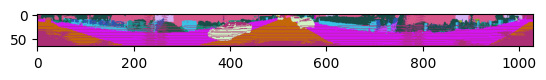

In [6]:
import cv2
import matplotlib.pyplot as plt

a = next(iter(refine_loader))['images_lidar'][0]
label_matrix = a[:,:,3].detach().cpu().numpy()
unique_labels = np.unique(label_matrix)
colors = {label: tuple(np.random.randint(0, 256, 3)) for label in unique_labels}
height, width = label_matrix.shape
color_image = np.zeros((height, width, 3), dtype=np.uint8)
for label, color in colors.items():
        color_image[label_matrix == label] = color
plt.imshow(color_image)

In [17]:
unique_labels

array([ 0.,  6.,  7.,  8.,  9., 11., 12., 13., 17., 21., 22., 26., 27.,
       30., 34., 35., 39., 42.], dtype=float16)

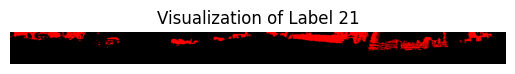

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Extract the label matrix
a = next(iter(refine_loader))['images_lidar'][0]
label_matrix = a[:, :, 3].detach().cpu().numpy()

# Create a mask for label 13
label_of_interest = 
mask = label_matrix == label_of_interest

# Generate a color image with the same dimensions
height, width = label_matrix.shape
color_image = np.zeros((height, width, 3), dtype=np.uint8)

# Assign a specific color to label 13 (e.g., red)
color_for_label = (255, 0, 0)  # RGB for red
color_image[mask] = color_for_label

# Display the image
plt.imshow(color_image)
plt.title(f"Visualization of Label {label_of_interest}")
plt.axis('off')
plt.show()


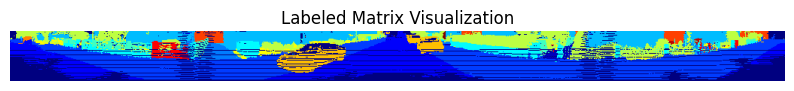

In [53]:
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}

# Create a normalized matrix where each label is replaced with its index
normalized_matrix = np.vectorize(label_to_index.get)(label_matrix)

# Scale the normalized matrix to [0, 255]
img_label = (normalized_matrix / (len(unique_labels) - 1) * 255).astype(np.uint8)

# Apply a colormap to visualize
img_colored = cv2.applyColorMap(img_label, cv2.COLORMAP_JET)

# Display using Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(img_colored, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for Matplotlib
plt.axis('off')
plt.title("Labeled Matrix Visualization")
plt.show()

In [30]:
np.vectorize(label_to_index.get)

AttributeError: 'vectorize' object has no attribute 'data'

In [23]:
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.backends.backend_pdf import PdfPages
# image_pil = Image.fromarray(a[:,:,0].cpu().numpy())
# pdf_path = "raydrop.pdf"
# image_pil.save(pdf_path, "PDF", resolution=500.0)
pdf_path = "label.pdf"
with PdfPages(pdf_path) as pdf:
    # plt.figure(figsize=(6, 6))  # Set figure size
    plt.figure(figsize=(8, 8), dpi=1000)
    plt.imshow(a[:,:,3].cpu().numpy())  # Display the image array
    plt.axis('off')  # Turn off axes
    pdf.savefig()  # Save the current figure to the PDF
    plt.close()


(66, 1030, 3)

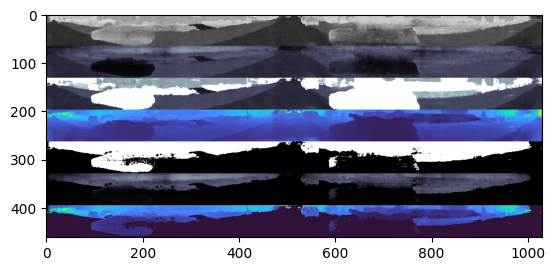

In [4]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
# Load the image
img = Image.open("log/kitti360_lidar4d_f4950_release/validation/lidar4d_ep0100_0001.png")  # Replace with your file path
plt.imshow(img,cmap='viridis', vmin=0.2, vmax=0.8)
from utils.convert import pano_to_lidar_with_intensities
a = np.load("data/kitti360/train/0000004951.npy")
a.shape

In [7]:
np.savetxt("4951.txt", pano_to_lidar_with_intensities(a[:,:, 1], a[:,:, 2], [2,26.9]))

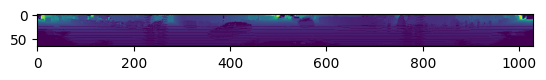

In [15]:
plt.imshow(a[:,:,2].cpu().numpy())

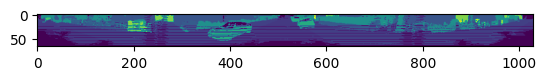

In [16]:
plt.imshow(a[:,:,3].cpu().numpy())

In [ ]:
optimizer = lambda model: torch.optim.Adam(
    model.get_params(opt.lr), betas=(0.9, 0.99), eps=1e-15
)

# decay to 0.1 * init_lr at last iter step
scheduler = lambda optimizer: torch.optim.lr_scheduler.LambdaLR(
    optimizer, lambda iter: 0.1 ** min(iter / opt.iters, 1)
)

trainer = Trainer(
    "lidar4d",
    opt,
    model,
    device=device,
    workspace=opt.workspace,
    criterion=criterion,
    fp16=opt.fp16,
    lidar_metrics=lidar_metrics,
    use_checkpoint="scratch",
    optimizer=optimizer,
    ema_decay=opt.ema_decay,
    lr_scheduler=scheduler,
    scheduler_update_every_step=True,
    eval_interval=opt.eval_interval,
)

max_epoch = np.ceil(opt.iters / len(train_loader)).astype(np.int32)
print(f"max_epoch: {max_epoch}")

In [ ]:
trainer.train(train_loader, valid_loader, refine_loader, max_epoch)

In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import MinkowskiEngine as ME

class LiDARScanDataset(Dataset):
    def __init__(
        self,
        folder_path: str,
        voxel_size: float = 0.05,
        use_intensity: bool = True,
        ignore_label: int = None
    ):
        self.folder_path = folder_path
        self.voxel_size = voxel_size
        self.use_intensity = use_intensity
        self.ignore_label = ignore_label
        self.file_list = self._get_file_list()

    def _get_file_list(self):
        return sorted(
            os.path.join(self.folder_path, f) 
            for f in os.listdir(self.folder_path) 
            if f.endswith(".txt")
        )

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx: int):
        # Load raw data from .txt file
        scan_data = np.loadtxt(self.file_list[idx])
        
        # Extract components
        coordinates = scan_data[:, :3].astype(np.float32)
        intensity = scan_data[:, 3].astype(np.float32).reshape(-1, 1)
        labels = scan_data[:, 4].astype(np.int32)
        
        # Handle features (intensity or ones)
        features = intensity if self.use_intensity else np.ones((coordinates.shape[0], 1), dtype=np.float32)

        # Voxel quantization
        quantized_coords, quantized_feats, quantized_labels, _ = ME.utils.sparse_quantize(
            coordinates=coordinates,
            features=features,
            labels=labels,
            ignore_label=self.ignore_label if self.ignore_label is not None else -100,
            quantization_size=self.voxel_size,
            return_index=True,
        )

        # Convert to tensors
        return {
            "coordinates": torch.from_numpy(quantized_coords),
            "features": torch.from_numpy(quantized_feats),
            "labels": torch.from_numpy(quantized_labels),
            "sampled_idx": None,  # No subsampling in this example
            "idx": torch.tensor(idx)
        }

def custom_collate_fn(batch):
    """Collate function that sorts data by number of points"""
    batch.sort(key=lambda x: x['coordinates'].shape[0], reverse=True)
    return batch

# Usage example
if __name__ == "__main__":
    LIDAR_FOLDER = '/root/docker_data/MSthesis/log/kitti360_lidar4d_f4950_release/simulation/points'
    
    dataset = LiDARScanDataset(
        folder_path=LIDAR_FOLDER,
        voxel_size=0.05,
        use_intensity=True,
        ignore_label=None
    )
    
    dataloader = DataLoader(
        dataset,
        batch_size=16,
        shuffle=True,
        collate_fn=custom_collate_fn
    )

    # Verify output format
    for batch in dataloader:
        sample = batch[0]
        print(f"Coordinates shape: {sample['coordinates'].shape}")
        print(f"Features shape: {sample['features'].shape}")
        print(f"Labels shape: {sample['labels'].shape}")
        break

In [7]:
import os
import numpy as np
import open3d as o3d
import imageio
import matplotlib.pyplot as plt

# Folder containing .txt files
folder_path = "/root/docker_data/MSthesis/log/kitti360_lidar4d_f4950_release/simulation/points"
output_gif = "point_cloud_animation.gif"

# Get sorted list of .txt files
file_list = sorted([f for f in os.listdir(folder_path) if f.endswith(".npy")])

# Define Open3D Visualizer
vis = o3d.visualization.Visualizer()
vis.create_window(visible=True)  # Open a visible window temporarily

# Create a point cloud object
pcd = o3d.geometry.PointCloud()

# Store frames
frames = []

# Iterate through each file
for idx, file in enumerate(file_list):
    file_path = os.path.join(folder_path, file)
    
    # Load the LiDAR data
    data = np.loadtxt(file_path)  # Assuming space-separated values
    
    # Extract x, y, z, and labels
    x, y, z, labels = data[:, 0], data[:, 1], data[:, 2], data[:, 4]  # Ignoring intensity

    # Assign points to Open3D PointCloud
    points = np.vstack((x, y, z)).T
    pcd.points = o3d.utility.Vector3dVector(points)

    # Assign colors based on labels (normalized for Open3D)
    label_colors = plt.get_cmap("jet")(labels / labels.max())[:, :3]  # Convert labels to RGB
    pcd.colors = o3d.utility.Vector3dVector(label_colors)

    # Add geometry and render
    vis.clear_geometries()
    vis.add_geometry(pcd)
    vis.poll_events()
    vis.update_renderer()

    # Get the view control AFTER rendering
    ctr = vis.get_view_control()
    ctr.set_lookat([np.mean(x), np.mean(y), np.mean(z)])  # Center the view
    ctr.set_front([0, -1, 0])  # Looking from the top
    ctr.set_up([0, 0, 1])  # Z-axis is up
    ctr.set_zoom(0.5)  # Adjust zoom level

    # Capture image
    image_path = f"frame_{idx:03d}.png"
    vis.capture_screen_image(image_path, do_render=True)
    frames.append(imageio.imread(image_path))

# Destroy Open3D visualizer
vis.destroy_window()

# Create GIF
imageio.mimsave(output_gif, frames, duration=0.1)  # Adjust duration for speed

print(f"GIF saved as {output_gif}")


[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


UnicodeDecodeError: 'utf-8' codec can't decode byte 0x93 in position 0: invalid start byte

In [6]:
import os
# Enable CPU rendering mode if necessary
os.environ["OPEN3D_CPU_RENDERING"] = "1"

import numpy as np
import open3d as o3d
import open3d.visualization.rendering as rendering

# Load point cloud from a text file (assumes one x y z per line)
points = np.loadtxt("/root/docker_data/MSthesis/log/kitti360_lidar4d_f4950_release/simulation/points/lidar4d_0046.txt")[:,:3]
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)

# Set up offscreen renderer with desired resolution
width, height = 800, 600
renderer = rendering.OffscreenRenderer(width, height)

# Create a simple material for the point cloud
material = rendering.MaterialRecord()
material.shader = "defaultUnlit"  # or choose another shader as needed

# Add the point cloud geometry to the scene
renderer.scene.add_geometry("point_cloud", pcd, material)

# Set up the camera view:
# Compute the bounding box center and extent for a reasonable camera position.
bbox = pcd.get_axis_aligned_bounding_box()
center = bbox.get_center()
extent = bbox.get_extent()
# Position the camera at a distance based on the point cloud size.
eye = [center[0] + extent[0]*2, center[1] + extent[1]*2, center[2] + extent[2]*2]
up = [0, 1, 0]
renderer.scene.camera.look_at(center, eye, up)

# Render the scene to an image
image = renderer.render_to_image()

# Save the rendered image to a PNG file
o3d.io.write_image("output.png", image)


: 

In [5]:
points.shape

(3, 5)

In [26]:
import os 
import numpy as np
import cv2
import matplotlib.pyplot as plt
def lidar_to_pano_with_intensities_and_labels(
    local_points_with_intensities_labels: np.ndarray,
    lidar_H: int,
    lidar_W: int,
    lidar_K: int,
    max_depth=80,
):
    """
    Convert lidar frame to pano frame with intensities and semantic labels.
    Lidar points are in local coordinates.

    Args:
        local_points_with_intensities_labels: (N, 5), float32, in lidar frame, with intensities and semantic labels.
        lidar_H: pano height.
        lidar_W: pano width.
        lidar_K: lidar intrinsics.
        max_depth: max depth in meters.

    Return:
        pano: (H, W), float32, depth values.
        intensities: (H, W), float32, intensity values.
        semantic_labels: (H, W), float32, semantic labels.
    """
    # Unpack points, intensities, and labels.
    local_points = local_points_with_intensities_labels[:, :3]
    local_point_intensities = local_points_with_intensities_labels[:, 3]
    local_point_labels = local_points_with_intensities_labels[:, 4]
    fov_up, fov = lidar_K
    fov_down = fov - fov_up

    # Compute distances to lidar center.
    dists = np.linalg.norm(local_points, axis=1)

    # Initialize output arrays.
    pano = np.zeros((lidar_H, lidar_W), dtype=np.float32)
    intensities = np.zeros((lidar_H, lidar_W), dtype=np.float32)
    semantic_labels = np.zeros((lidar_H, lidar_W), dtype=np.float32)

    for local_point, dist, intensity, label in zip(
        local_points, dists, local_point_intensities, local_point_labels
    ):
        # Check max depth.
        if dist >= max_depth:
            continue

        x, y, z = local_point
        beta = np.pi - np.arctan2(y, x)
        alpha = np.arctan2(z, np.sqrt(x**2 + y**2)) + fov_down / 180 * np.pi
        c = int(round(beta / (2 * np.pi / lidar_W)))
        r = int(round(lidar_H - alpha / (fov / 180 * np.pi / lidar_H)))

        # Check out-of-bounds.
        if r >= lidar_H or r < 0 or c >= lidar_W or c < 0:
            continue

        # Set to min dist if not set, or if this distance is closer.
        if pano[r, c] == 0.0 or pano[r, c] > dist:
            pano[r, c] = dist
            intensities[r, c] = intensity
            semantic_labels[r, c] = label

    return pano, intensities, semantic_labels


gt_folder = "/root/docker_data/MSthesis/data/kitti360/train"
sim_folder = "/root/docker_data/MSthesis/log/kitti360_lidar4d_f4950_release/simulation/points"

# Example: sort numerically if filenames are like 'scan_12.npy'
gt_files = sorted(
    [f for f in os.listdir(gt_folder) if f.endswith(".npy")]
    )
    
sim_files = sorted(
    [f for f in os.listdir(sim_folder) if f.endswith(".npy")],
    key=lambda x: int(x.split('_')[1].split('.')[0])
)


simulated_scans = []
for file in sim_files:
    print(file)
    sim_scan = np.load(sim_folder + "/"+file)
    x,y,sim_label_map = lidar_to_pano_with_intensities_and_labels(sim_scan, 66,1030, (2,26.9))
    simulated_scans.append(sim_label_map)


label_mapping = {
    0: 0,
    8: 1,
    7: 2,
    11: 3,
    26: 4,
    21: 5,
    100: 6
}
ground_truth_scans = []
for file in gt_files:
    gt_label_map = np.load(gt_folder + "/" + file)[:, :, 3]

    # Apply label remapping
    remapped_map = np.copy(gt_label_map)
    for old_label, new_label in label_mapping.items():
        remapped_map[gt_label_map == old_label] = new_label

    ground_truth_scans.append(remapped_map)


lidar4d_0000.npy
lidar4d_0001.npy
lidar4d_0002.npy
lidar4d_0003.npy
lidar4d_0004.npy
lidar4d_0005.npy
lidar4d_0006.npy
lidar4d_0007.npy
lidar4d_0008.npy
lidar4d_0009.npy
lidar4d_0010.npy
lidar4d_0011.npy
lidar4d_0012.npy
lidar4d_0013.npy
lidar4d_0014.npy
lidar4d_0015.npy
lidar4d_0016.npy
lidar4d_0017.npy
lidar4d_0018.npy
lidar4d_0019.npy
lidar4d_0020.npy
lidar4d_0021.npy
lidar4d_0022.npy
lidar4d_0023.npy
lidar4d_0024.npy
lidar4d_0025.npy
lidar4d_0026.npy
lidar4d_0027.npy
lidar4d_0028.npy
lidar4d_0029.npy
lidar4d_0030.npy
lidar4d_0031.npy
lidar4d_0032.npy
lidar4d_0033.npy
lidar4d_0034.npy
lidar4d_0035.npy
lidar4d_0036.npy
lidar4d_0037.npy
lidar4d_0038.npy
lidar4d_0039.npy
lidar4d_0040.npy
lidar4d_0041.npy
lidar4d_0042.npy
lidar4d_0043.npy
lidar4d_0044.npy
lidar4d_0045.npy
lidar4d_0046.npy
lidar4d_0047.npy
lidar4d_0048.npy
lidar4d_0049.npy
lidar4d_0050.npy


In [27]:
import numpy as np

num_classes = len(label_mapping)  # 7 in your case
ious_per_class = np.zeros((len(simulated_scans), num_classes), dtype=np.float32)

for i, (pred, gt) in enumerate(zip(simulated_scans, ground_truth_scans)):
    for cls in range(num_classes):
        intersection = np.logical_and(pred == cls, gt == cls).sum()
        union = np.logical_or(pred == cls, gt == cls).sum()
        
        if union == 0:
            iou = np.nan  # no pixels of this class in either pred or gt
        else:
            iou = intersection / union
        
        ious_per_class[i, cls] = iou

# Mean IoU per class across all pairs (ignoring NaNs)
mean_iou_per_class = np.nanmean(ious_per_class, axis=0)

# mIoU = average of per-class IoUs
miou = np.nanmean(mean_iou_per_class)

print("Class-wise IoU:", mean_iou_per_class)
print("mIoU:", miou)


Class-wise IoU: [0.91618806 0.9398015  0.9498321  0.91790694 0.7980215  0.87842345
 0.8410119 ]
mIoU: 0.89159787


In [31]:
import numpy as np

def iou_per_class(pred, gt, num_classes):
    """
    Calculate IoU for each class between two label maps.

    Args:
        pred (np.ndarray): predicted labels (H, W)
        gt (np.ndarray): ground truth labels (H, W)
        num_classes (int): total number of classes

    Returns:
        np.ndarray: IoU for each class (size = num_classes)
    """
    ious = np.zeros(num_classes, dtype=np.float32)

    for cls in range(num_classes):
        intersection = np.logical_and(pred == cls, gt == cls).sum()
        union = np.logical_or(pred == cls, gt == cls).sum()

        if union == 0:
            ious[cls] = np.nan  # class not present in either
        else:
            ious[cls] = intersection / union

    return ious

# Store IoUs for each frame
all_ious = []

for pred_map, gt_map in zip(simulated_scans, ground_truth_scans):
    ious = iou_per_class(pred_map, gt_map, num_classes=7)
    all_ious.append(ious)

# Convert to NumPy array: shape = (num_frames, num_classes)
all_ious = np.array(all_ious)

# Mean IoU per class across all frames
mean_iou_per_class = np.nanmean(all_ious, axis=0)

# mIoU (mean over classes)
miou = np.nanmean(mean_iou_per_class)

print("Class-wise IoU:", mean_iou_per_class)
print("mIoU:", miou)



Class-wise IoU: [0.91618806 0.9398015  0.9498321  0.91790694 0.7980215  0.87842345
 0.8410119 ]
mIoU: 0.89159787
